# Data Pre-Processing

## Data Loading
- **File Reading:** Load signal files from the specified directories for healthy and patient groups
- **Label Assignment:** Assign a numerical label to each file based on its category (healthy or patient) for supervised learning.

In [37]:
# Cell 1: Imports and Setup (Updated channel names)
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import re

pd.set_option('display.max_columns', None)

# Base paths configuration
base_paths = {
    "healthy": r"C:\NewHandPD\Healthy Signals\Signal",
    "patient": r"C:\NewHandPD\Patient Signals\Signal"
}

category_labels = {
    "healthy": 0,
    "patient": 1
}

# Updated channel names (excluding Microphone)
channel_names = [
    "Fingergrip", "Axial_Pressure",
    "Tilt_X", "Tilt_Y", "Tilt_Z"
]

## Data Parsing
- **Metadata Extraction:** Extract relevant metadata from each file, such as subject information and recording parameters, to enrich the dataset.
- **Signal Processing:** Parse and structure the signal data, dropping unnecessary channels (e.g., Microphone) and keeping only the relevant sensor channels.

In [38]:
# Cell 2: Enhanced File Parsing Function with Metadata Extraction
def parse_signal_file(file_path, label):
    with open(file_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()

    meta_info = {}
    signal_start_idx = 0
    in_meta_section = False

    # Extract metadata
    for i, line in enumerate(lines):
        line = line.strip()
        
        if line == "#<meta>":
            in_meta_section = True
            continue
        elif line == "#</meta>":
            in_meta_section = False
            signal_start_idx = i + 1
            break
            
        if in_meta_section and line.startswith("#<") and line.endswith(">"):
            # Extract key-value pairs from metadata
            try:
                key = line[2:line.find(">")]  # Get text between #< and >
                value = line[line.find(">")+1:-1]  # Get text between > and <
                
                # Convert numeric values to appropriate type
                if value.isdigit():
                    value = int(value)
                elif value.replace('.', '', 1).isdigit():
                    value = float(value)
                elif value.lower() == 'true':
                    value = True
                elif value.lower() == 'false':
                    value = False
                elif value == '':
                    value = None
                    
                meta_info[key] = value
            except:
                continue

    # Load signal data and drop first channel (Microphone)
    signal_lines = lines[signal_start_idx:]
    signal_array = np.loadtxt(signal_lines, delimiter="\t")
    
    # Keep only channels 1-5 (drop channel 0 - Microphone)
    if signal_array.ndim == 1:
        signal_array = signal_array[1:6].reshape(1, -1)  # For single-row signals
    else:
        signal_array = signal_array[:, 1:6]  # For multi-row signals

    return signal_array, label, meta_info

In [39]:
# Cell 3: Main Processing (Now includes metadata in records)
all_records = []
sigMea_records = []
sigSp_records = []

for category, folder_path in base_paths.items():
    label = category_labels[category]
    print(f"Processing {category} files...")

    for file_name in tqdm(os.listdir(folder_path)):
        if not file_name.endswith(".txt"):
            continue
            
        file_path = os.path.join(folder_path, file_name)
        try:
            signal_data, label_val, meta_info = parse_signal_file(file_path, label)

            record = {
                "file_name": file_name,
                "label": label_val,
                "signal": signal_data,
                **meta_info  # Unpack all metadata into the record
            }

            all_records.append(record)
            
            # Filter for specific file prefixes
            if file_name.startswith("sigMea"):
                sigMea_records.append(record)
            elif file_name.startswith("sigSp"):
                sigSp_records.append(record)

        except Exception as e:
            print(f"Error parsing {file_name}: {e}")

Processing healthy files...


100%|██████████| 421/421 [00:06<00:00, 61.19it/s]


Processing patient files...


100%|██████████| 373/373 [00:09<00:00, 37.73it/s]


In [40]:
# Cell 4: Create DataFrames (Now includes metadata columns)
df_all = pd.DataFrame(all_records)
df_sigMea = pd.DataFrame(sigMea_records)
df_sigSp = pd.DataFrame(sigSp_records)

print(f"\nSummary:")
print(f"Total files processed: {len(all_records)}")
print(f"Files starting with 'sigMea': {len(sigMea_records)}")
print(f"Files starting with 'sigSp': {len(sigSp_records)}")

# Show metadata columns we've extracted
print("\nMetadata columns found:")
print([col for col in df_all.columns if col not in ['file_name', 'label', 'signal']])


Summary:
Total files processed: 792
Files starting with 'sigMea': 264
Files starting with 'sigSp': 264

Metadata columns found:
['Person_ID_Number', 'Age', 'Gender', 'Writing_Hand', 'Weight', 'Height', 'Smoker', 'Notice', 'Object', 'Object_Index', 'Pen', 'Samplerate', 'Time', 'Date', 'Comment', 'Surename', 'Forename']


In [41]:
# --- Cell 4.1: Keep only the core metadata columns ---
core_cols = ['file_name', 'label', 'signal', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']

# Check which columns exist before selecting to avoid errors if some metadata is missing
def select_existing_cols(df, cols):
    existing_cols = [col for col in cols if col in df.columns]
    return df[existing_cols]

df_all = select_existing_cols(df_all, core_cols)
df_sigMea = select_existing_cols(df_sigMea, core_cols)
df_sigSp = select_existing_cols(df_sigSp, core_cols)

## Data Cleaning
- **Missing and Outlier Data Handling:** Remove records with missing values or impossible signal values (e.g., negative physical measurements) to ensure data quality.
- **Signal Normalization:** Apply min-max scaling to each signal channel so all features are on a comparable scale, improving model performance and interpretability.

In [42]:
# Cell 5: Data Cleaning for DataFrames
# Remove rows with missing or NaN values in key columns
df_all_clean = df_all.dropna(subset=['signal', 'label', 'file_name'])
df_sigMea_clean = df_sigMea.dropna(subset=['signal', 'label', 'file_name'])
df_sigSp_clean = df_sigSp.dropna(subset=['signal', 'label', 'file_name'])

# Remove rows with impossible values (e.g., negative values for physical signals)
def remove_impossible_values(df):
    # Example: Remove rows where any signal value is negative
    mask = df['signal'].apply(lambda x: np.all(x >= 0))
    return df[mask]

df_all_clean = remove_impossible_values(df_all_clean)
df_sigMea_clean = remove_impossible_values(df_sigMea_clean)
df_sigSp_clean = remove_impossible_values(df_sigSp_clean)

# Normalize signal data (min-max scaling per sample)
def normalize_signal(signal):
    min_val = np.min(signal, axis=0)
    max_val = np.max(signal, axis=0)
    # Avoid division by zero
    denom = np.where(max_val - min_val == 0, 1, max_val - min_val)
    return (signal - min_val) / denom

df_all_clean['signal'] = df_all_clean['signal'].apply(normalize_signal)
df_sigMea_clean['signal'] = df_sigMea_clean['signal'].apply(normalize_signal)
df_sigSp_clean['signal'] = df_sigSp_clean['signal'].apply(normalize_signal)

print('Data cleaning complete:')
print(f'df_all_clean shape: {df_all_clean.shape}')
print(f'df_sigMea_clean shape: {df_sigMea_clean.shape}')
print(f'df_sigSp_clean shape: {df_sigSp_clean.shape}')

# Check for missing values in each DataFrame
print("\nMissing values in df_all_clean:", df_all_clean.isna().sum().sum())
print("Missing values in df_sigMea_clean:", df_sigMea_clean.isna().sum().sum())
print("Missing values in df_sigSp_clean:", df_sigSp_clean.isna().sum().sum())

# To see which columns have missing values:
print("\nColumns with missing values in df_all_clean:")
print(df_all_clean.isna().sum()[df_all_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigMea_clean:")
print(df_sigMea_clean.isna().sum()[df_sigMea_clean.isna().sum() > 0])

print("\nColumns with missing values in df_sigSp_clean:")
print(df_sigSp_clean.isna().sum()[df_sigSp_clean.isna().sum() > 0])

Data cleaning complete:
df_all_clean shape: (789, 7)
df_sigMea_clean shape: (262, 7)
df_sigSp_clean shape: (263, 7)

Missing values in df_all_clean: 0
Missing values in df_sigMea_clean: 0
Missing values in df_sigSp_clean: 0

Columns with missing values in df_all_clean:
Series([], dtype: int64)

Columns with missing values in df_sigMea_clean:
Series([], dtype: int64)

Columns with missing values in df_sigSp_clean:
Series([], dtype: int64)


# Data Splitting
- **Person-Based Splitting:** Divide the dataset into training, validation, and test sets based on unique person identifiers to prevent data leakage and ensure fair evaluation.
- **Randomization:** Shuffle person IDs before splitting to ensure unbiased distribution across splits.
- **Split Proportions:** Assign approximately 70% of persons to training, 15% to validation, and 15% to test sets for balanced model development and assessment.
- **Leakage Check:** Verify that no person appears in more than one split to maintain strict separation between training and evaluation data."

In [43]:
# --- Cell 6: Combine sigMea and sigSp DataFrames ---
# Use the CLEANED dataframes from the previous cell, not the original ones.
df_combined = pd.concat([df_sigMea_clean, df_sigSp_clean], ignore_index=True)
print(f"Combined DataFrame shape: {df_combined.shape}")

Combined DataFrame shape: (525, 7)


In [44]:
# Cell 6.1: Split data by Person_ID_Number
import numpy as np

# Extract unique Person IDs
person_ids = df_combined['Person_ID_Number'].unique()

# Random shuffle of Person IDs
np.random.seed(42)  # for reproducibility
np.random.shuffle(person_ids)

# Calculate split indices
n_ids = len(person_ids)
train_idx = int(0.7 * n_ids)
val_idx = int(0.85 * n_ids)

# Split Person IDs into train, validation, and test sets
train_ids = person_ids[:train_idx]
val_ids = person_ids[train_idx:val_idx]
test_ids = person_ids[val_idx:]

# Create DataFrames for each split
df_train = df_combined[df_combined['Person_ID_Number'].isin(train_ids)]
df_val = df_combined[df_combined['Person_ID_Number'].isin(val_ids)]
df_test = df_combined[df_combined['Person_ID_Number'].isin(test_ids)]

print("\nData Split Summary:")
print(f"Total number of unique persons: {n_ids}")
print(f"Training set: {len(train_ids)} persons, {len(df_train)} samples")
print(f"Validation set: {len(val_ids)} persons, {len(df_val)} samples")
print(f"Test set: {len(test_ids)} persons, {len(df_test)} samples")

# Verify no data leakage
train_ids_set = set(df_train['Person_ID_Number'].unique())
val_ids_set = set(df_val['Person_ID_Number'].unique())
test_ids_set = set(df_test['Person_ID_Number'].unique())

print("\nChecking for data leakage:")
print("Overlap between train and val:", len(train_ids_set & val_ids_set))
print("Overlap between train and test:", len(train_ids_set & test_ids_set))
print("Overlap between val and test:", len(val_ids_set & test_ids_set))


Data Split Summary:
Total number of unique persons: 61
Training set: 42 persons, 365 samples
Validation set: 9 persons, 80 samples
Test set: 10 persons, 80 samples

Checking for data leakage:
Overlap between train and val: 0
Overlap between train and test: 0
Overlap between val and test: 0


# Feature Engineering
- **Statistical Features:** Compute basic statistics (mean, standard deviation, min, max, range, median) for each signal channel to capture essential characteristics of the data.
- **Derivative Features:** Calculate first and second derivatives (jerk and snap) of the signals to quantify dynamic changes and motion patterns.
- **Sliding Window Segmentation:** Segment each signal into overlapping windows to extract localized features, improving the model's ability to detect temporal patterns.
- **Delta Features:** Compute the change (delta) in feature values between consecutive windows for each file, capturing transitions and trends within the signal.

In [45]:
# Cell 7: Simplified Feature extraction helpers
def compute_basic_stats(signal):
    """Compute only basic statistics without entropy or zero crossings"""
    return {
        "mean": np.mean(signal),
        "std": np.std(signal),
        "min": np.min(signal),
        "max": np.max(signal),
        "range": np.max(signal) - np.min(signal),
        "median": np.median(signal),
    }

def compute_derivatives(signal, order=1, sampling_rate=1000):
    """Compute derivatives up to snap (2nd derivative)"""
    dt = 1 / sampling_rate
    derivative = signal.copy()
    for _ in range(order):
        derivative = np.gradient(derivative, dt)
    return derivative

def compute_mass(signal):
    """Compute motion mass (sum of absolute values)"""
    return np.sum(np.abs(signal))

def extract_features_from_window(window_data, sampling_rate=1000):
    """Simplified feature extraction without entropy or zero crossings"""
    features = {}
    
    for i, channel in enumerate(channel_names):
        signal = window_data[:, i]
        stats = compute_basic_stats(signal)
        for stat_name, stat_val in stats.items():
            features[f"{channel}_{stat_name}"] = stat_val

        # First and second derivatives
        jerk = compute_derivatives(signal, order=1, sampling_rate=sampling_rate)
        snap = compute_derivatives(signal, order=2, sampling_rate=sampling_rate)

        # Only mass features
        features[f"{channel}_jerk_mass"] = compute_mass(jerk)
        features[f"{channel}_snap_mass"] = compute_mass(snap)

    return features

In [46]:
# Cell 8: Enhanced Sliding window feature extraction with metadata
window_size = 1000  # 1 second
step_size = 500     # 50% overlap
sampling_rate = 1000

def extract_features_from_df(df):
    features = []
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        signal = row["signal"]
        label = row["label"]
        file_name = row["file_name"]
        
        # Get all metadata columns (excluding signal, label, and file_name)
        metadata = {k: v for k, v in row.items() 
                   if k not in ['signal', 'label', 'file_name']}

        if signal.shape[0] < window_size:
            continue  # Skip very short signals

        for start in range(0, signal.shape[0] - window_size + 1, step_size):
            end = start + window_size
            window_data = signal[start:end, :]

            window_features = extract_features_from_window(window_data, sampling_rate)
            window_features["label"] = label
            window_features["file_name"] = file_name
            window_features["start_index"] = start
            window_features["end_index"] = end
            
            # Add all metadata to the window features
            window_features.update(metadata)

            features.append(window_features)
    
    return pd.DataFrame(features)

# Extract features for each split
print("Extracting features for training set...")
df_features_train = extract_features_from_df(df_train)
print("Extracting features for validation set...")
df_features_val = extract_features_from_df(df_val)
print("Extracting features for test set...")
df_features_test = extract_features_from_df(df_test)

print("\nFeature extraction complete:")
print(f"Training set shape: {df_features_train.shape}")
print(f"Validation set shape: {df_features_val.shape}")
print(f"Test set shape: {df_features_test.shape}")

Extracting features for training set...


100%|██████████| 365/365 [00:11<00:00, 31.94it/s]


Extracting features for validation set...


100%|██████████| 80/80 [00:03<00:00, 23.23it/s]


Extracting features for test set...


100%|██████████| 80/80 [00:02<00:00, 39.17it/s]


Feature extraction complete:
Training set shape: (11372, 48)
Validation set shape: (3503, 48)
Test set shape: (1994, 48)


In [47]:
# Cell 9: Add delta features (Now preserves metadata columns)
def add_delta_features(df):
    delta_features = []
    grouped = df.groupby("file_name")

    # Define known metadata columns (these are columns we know are not feature columns)
    base_non_feature_cols = [
    'label', 'file_name', 'start_index', 'end_index',
    'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand'
    ]
    
    # Identify potential metadata columns (columns that are constant within each file)
    potential_metadata_cols = [
        col for col in df.columns 
        if col not in base_non_feature_cols 
        and df.groupby('file_name')[col].nunique().max() == 1
    ]
    
    # Combine base non-feature columns with metadata columns
    non_feature_cols = base_non_feature_cols + potential_metadata_cols

    for file_name, group in grouped:
        group = group.sort_values("start_index").reset_index(drop=True)
        group_delta = group.copy()

        # Identify feature columns (excluding non-feature columns)
        feature_cols = [col for col in group.columns if col not in non_feature_cols]
        
        # Compute deltas only for feature columns
        for col in feature_cols:
            group_delta[f"delta_{col}"] = group[col].diff()

        # Fill first row deltas with 0
        delta_cols = [f"delta_{col}" for col in feature_cols]
        group_delta.loc[0, delta_cols] = 0

        delta_features.append(group_delta)

    return pd.concat(delta_features, ignore_index=True)

# Process each split
print("Adding delta features to training set...")
df_delta_train = add_delta_features(df_features_train)
print("Adding delta features to validation set...")
df_delta_val = add_delta_features(df_features_val)
print("Adding delta features to test set...")
df_delta_test = add_delta_features(df_features_test)

print("\nFinal shapes:")
print(f"Training set: {df_delta_train.shape}")
print(f"Validation set: {df_delta_val.shape}")
print(f"Test set: {df_delta_test.shape}")

# Show columns with missing values and how many missing in each
print("\nColumns with missing values in df_delta_train:")
print(df_delta_train.isna().sum()[df_delta_train.isna().sum() > 0])

print("\nColumns with missing values in df_delta_val:")
print(df_delta_val.isna().sum()[df_delta_val.isna().sum() > 0])

print("\nColumns with missing values in df_delta_test:")
print(df_delta_test.isna().sum()[df_delta_test.isna().sum() > 0])

Adding delta features to training set...
Adding delta features to validation set...
Adding delta features to test set...

Final shapes:
Training set: (11372, 88)
Validation set: (3503, 88)
Test set: (1994, 88)

Columns with missing values in df_delta_train:
Series([], dtype: int64)

Columns with missing values in df_delta_val:
Series([], dtype: int64)

Columns with missing values in df_delta_test:
Series([], dtype: int64)


# Model Training: Bidirectional LSTM (BiLSTM)
- **Data Reshaping:** Adapting the 2D feature sets into the 3D format required by LSTMs (samples, timesteps, features).
- **Model Building:** Constructing a BiLSTM model using TensorFlow/Keras with Dropout for regularization.
- **Model Training:** Training the model using EarlyStopping to prevent overfitting and ModelCheckpoint to save the best version.
Performance Evaluation: Assessing the final model on the test set using the same metrics as before.

In [48]:
# Cell 10: Imports for BiLSTM Modeling
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [49]:
# Cell 11: Prepare and Scale Data for the Model

# Define feature columns (all numeric columns except metadata and label)
non_feature_cols = ['label', 'file_name', 'start_index', 'end_index', 'Person_ID_Number', 'Age', 'Gender', 'Writing_Hand']
feature_cols = [col for col in df_delta_train.columns if col not in non_feature_cols and pd.api.types.is_numeric_dtype(df_delta_train[col])]

# Separate features (X) and labels (y)
X_train = df_delta_train[feature_cols]
y_train = df_delta_train['label']

X_val = df_delta_val[feature_cols]
y_val = df_delta_val['label']

X_test = df_delta_test[feature_cols]
y_test = df_delta_test['label']

# Scale the features
scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)

# Transform the validation and test data using the fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Data prepared and scaled for modeling.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_val_scaled shape: {X_val_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")

Data prepared and scaled for modeling.
X_train_scaled shape: (11372, 80)
X_val_scaled shape: (3503, 80)
X_test_scaled shape: (1994, 80)


In [50]:
# Cell 12: Reshape Data for LSTM

# LSTMs expect 3D input: (samples, timesteps, features). Here, timesteps=1.
n_features = X_train_scaled.shape[1]
X_train_reshaped = X_train_scaled.reshape(-1, 1, n_features)
X_val_reshaped = X_val_scaled.reshape(-1, 1, n_features)
X_test_reshaped = X_test_scaled.reshape(-1, 1, n_features)

print("\nData shape after reshaping for LSTM:")
print(f"X_train_reshaped: {X_train_reshaped.shape}")
print(f"X_val_reshaped: {X_val_reshaped.shape}")
print(f"X_test_reshaped: {X_test_reshaped.shape}")


Data shape after reshaping for LSTM:
X_train_reshaped: (11372, 1, 80)
X_val_reshaped: (3503, 1, 80)
X_test_reshaped: (1994, 1, 80)


In [51]:
# Cell 13: Build the BiLSTM Model
def build_bilstm_model(input_shape):
    model = Sequential([
        Bidirectional(LSTM(128, kernel_regularizer=l2(0.0001)), input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu', kernel_regularizer=l2(0.0001)), 
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=0.0001), # Keep the stable learning rate
        metrics=['accuracy']
    )
    return model

input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])
bilstm_model = build_bilstm_model(input_shape)
bilstm_model.summary()

c:\Users\Tristan\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 256)            │       214,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 230,529 (900.50 KB)

 Trainable params: 230,529 (900.50 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Cell 14: Train the BiLSTM Model
checkpoint = ModelCheckpoint(
    'best_bilstm_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,      # Reduce learning rate by a factor of 5
    patience=5,      # Reduce after 5 epochs with no improvement
    min_lr=0.00001,  # Don't go below this learning rate
    verbose=1
)

history = bilstm_model.fit(
    X_train_reshaped,
    y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_val_reshaped, y_val),
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

Epoch 1/100
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6345 - loss: 0.7013
Epoch 1: val_loss improved from None to 0.63604, saving model to best_bilstm_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - accuracy: 0.6588 - loss: 0.6834 - val_accuracy: 0.6925 - val_loss: 0.6360 - learning_rate: 1.0000e-04
Epoch 2/100
177/178 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6943 - loss: 0.6343
Epoch 2: val_loss improved from 0.63604 to 0.58697, saving model to best_bilstm_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7029 - loss: 0.6214 - val_accuracy: 0.7051 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 3/100
174/178 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7242 - loss: 0.5850
Epoch 3: val_loss improved from 0.58697 to 0.55738, saving model to best_bilstm_model.keras
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.7328 - loss: 0.5757 - val_accuracy: 0.7259 - val_loss: 0.5574 - learning_rate: 1.0000e-04
Epoch 4/100
178/178 ━━━━━━━━━━

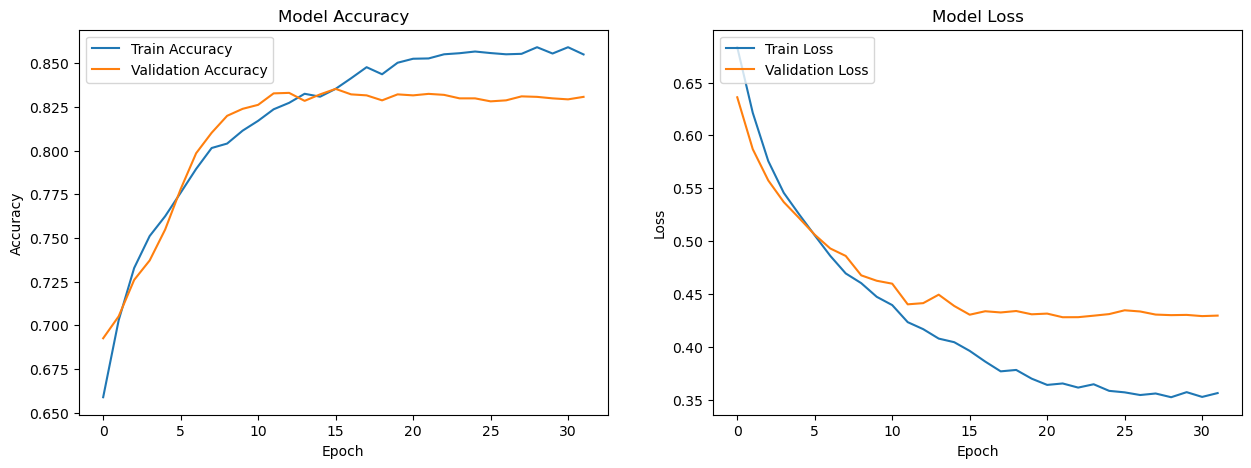

In [53]:
# Cell 15: Plot Training History
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.plot(history.history['accuracy'], label='Train Accuracy')
ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_title('Model Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.legend(loc='upper left')

ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Validation Loss')
ax2.set_title('Model Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.legend(loc='upper left')
plt.show()

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step

BiLSTM Test Set Accuracy: 0.7909

BiLSTM Classification Report:
              precision    recall  f1-score   support

     Healthy       0.88      0.70      0.78      1053
     Patient       0.73      0.89      0.80       941

    accuracy                           0.79      1994
   macro avg       0.80      0.80      0.79      1994
weighted avg       0.81      0.79      0.79      1994

BiLSTM Confusion Matrix:


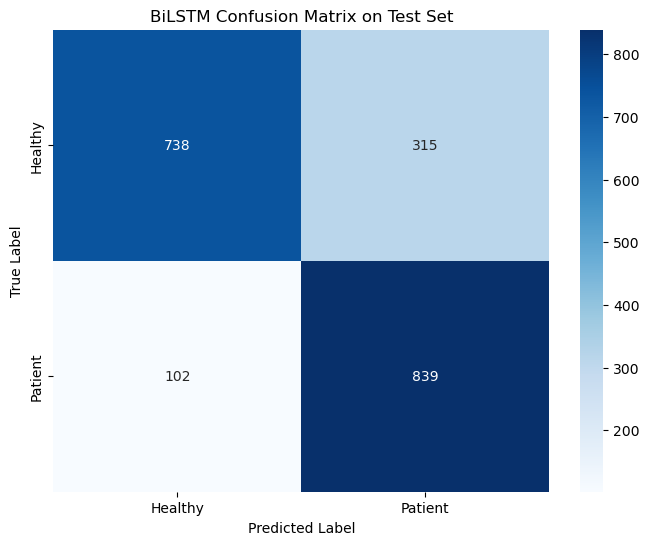

In [54]:
# Cell 16: Evaluate the BiLSTM Model on the Test Set
y_pred_probs = bilstm_model.predict(X_test_reshaped)
y_pred_classes = (y_pred_probs > 0.5).astype(int).flatten()

bilstm_accuracy = accuracy_score(y_test, y_pred_classes)
print(f"\nBiLSTM Test Set Accuracy: {bilstm_accuracy:.4f}\n")

print("BiLSTM Classification Report:")
print(classification_report(y_test, y_pred_classes, target_names=['Healthy', 'Patient']))

print("BiLSTM Confusion Matrix:")
cm_bilstm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_bilstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Patient'], yticklabels=['Healthy', 'Patient'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('BiLSTM Confusion Matrix on Test Set')
plt.show()